## Chapter 10. 数据工作

### 10.1 探索你的数据

#### 10.1.1 探索一维数据
对于一维数据，第一步显然是计算一些总结性统计数据。 比如你可能想知道你的数据集中有多少个数据点、最小值是多少、最大值是多少、平均值是多少、或者标准差是多少。

如果你仍不能很好地理解以上步骤，那么下一步最好是绘出直方图，即将你的数据分组成离散的区间（bucket），并对落入每个区间的数据点进行计数。

首先导入本章使用的包和函数(简单起见，我把需要的函数所在的py文件放在了~/.ipython目录下)：

In [1]:
import matplotlib.pyplot as plt
import math, random, csv
from probability import *
from linear_algebra import *
from stats import *

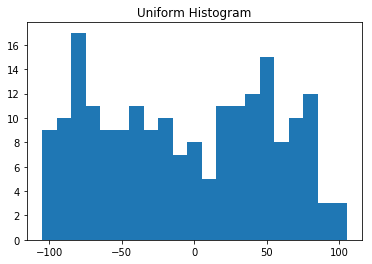

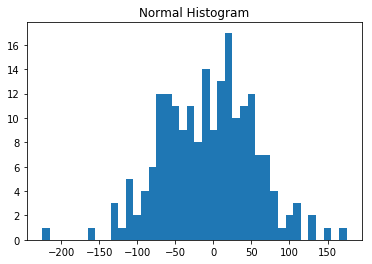

In [2]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(list(histogram.keys()), list(histogram.values()), width=bucket_size)
    plt.title(title)
    plt.show()

random.seed(0)

def compare_two_distributions():
    random.seed(0)
    uniform = [random.randrange(-100,101) for _ in range(200)]
    normal = [57 * inverse_normal_cdf(random.random()) for _ in range(200)]
    plot_histogram(uniform, 10, "Uniform Histogram")
    plot_histogram(normal, 10, "Normal Histogram")
    
compare_two_distributions()

#### 10.1.2 二维数据
现在假设你的数据集是二维的。也许在每天上网时间之外还增加了数据科学工作年限。你当然会希望能从每个维度上单独理解数据，但也许你更希望综合两个维度来考察数据。

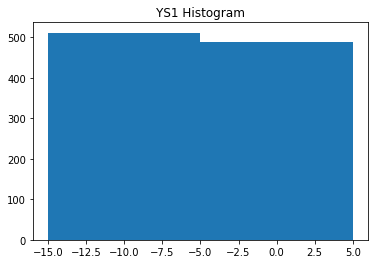

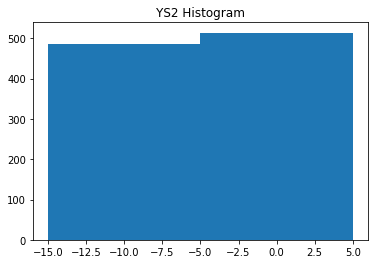

In [3]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

def compare_ys1_ys2_distributions():
    plot_histogram(ys1, 10, "YS1 Histogram")
    plot_histogram(ys2, 10, "YS2 Histogram")

compare_ys1_ys2_distributions()

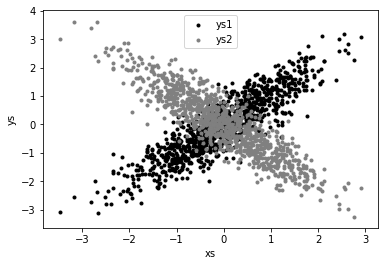

In [4]:
def scatter():
    plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
    plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
    plt.xlabel('xs')
    plt.ylabel('ys')
    plt.legend(loc=9)
    plt.show()

scatter()

如果你考察相关性，差异会非常明显：

In [5]:
correlation(xs, ys1), correlation(xs, ys2)

(0.891585944012268, -0.8939937075957362)

#### 10.1.3 多维数据
对于多维数据，你可能想了解各个维度之间是如何相关的。一个简单的方法是考察相关矩阵（correlation matrix） ，矩阵中第i行第j列的元素表示第i维与第j维数据的相关性：

In [6]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""
    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

一个更为直观的方法（如果维度不太多）是做散点图矩阵（图10-4），以展示配对散点图：

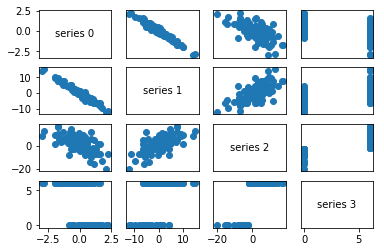

In [7]:
def make_scatterplot_matrix():
    # first, generate some random data
    num_points = 100

    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row() for _ in range(num_points)]

    # then plot it
    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())
    plt.show()
    
make_scatterplot_matrix()

### 10.2 清理与修改
skip!

### 10.3 数据处理
skip!

### 10.4 
许多技术对数据单位（scale）敏感。比如，假设你有一个包括数百名数据科学家的身高和体重的数据集，并且需要创建体型大小的聚类（cluster）。

直观上讲，我们用聚类表示相近的点，这意味着我们需要某种点距离的概念。我们知道有欧几里得距离函数distance ，所以自然地，一种方法是将数据对 (height, weight) 视为二维空间中的点：
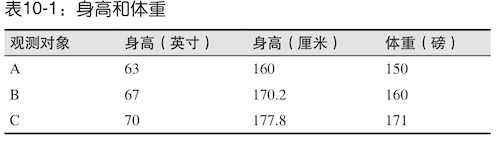

如果我们用英寸作为身高的单位，那么B最近的邻居是A：

In [10]:
a_to_b = distance([63, 150], [67, 160])
a_to_c = distance([63, 150], [70, 171])
b_to_c = distance([67, 160], [70, 171])
a_to_b, a_to_c, b_to_c

(10.770329614269007, 22.135943621178654, 11.40175425099138)

但是，如果用厘米作为单位，那么B最近的邻居变成了C：

In [11]:
a_to_b = distance([160, 150], [170.2, 160]) 
a_to_c = distance([160, 150], [177.8, 171])
b_to_c = distance([170.2, 160], [177.8, 171])
a_to_b, a_to_c, b_to_c

(14.284257068535268, 27.52889391167034, 13.370115930686627)

因此，如果不同的维度之间不可比较，就需要对数据进行调整，以使得每个维度的均值为0，标准差为1。这种转换有效地摆脱了单位带来的问题，将每个维度转化为“与均值的标准差”(即Z-score标准化方法)：

In [13]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [14]:
# 测试数据标准化
data = [[1, 20, 2], [1, 30, 3], [1, 40, 4]]
scale(data)

([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])

In [15]:
rescale(data)

[[1, -1.0, -1.0], [1, 0.0, 0.0], [1, 1.0, 1.0]]

### 10.5 降维
